In [27]:
libraries = c("dplyr", "tidyverse", "magrittr", "matrixStats")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}

options(scipen=10000)
theme_set(theme_bw())
version$version.string

[1] "R version 4.2.2 (2022-10-31)"

# Data

In [28]:
#### setting
start_date <- as.Date("2022-04-17")+1 ## symptom onset date of the initial case in the UK + 1 (for the convolution)

In [29]:
#### data for the model with depletion effect
read.csv("../data/input_WHO_backproj_conv.csv") -> df_input
df_input$date <- as.Date(df_input$date)
df_input$date_import <- as.Date(df_input$date_import)
censor_import <- max(df_input$date)

## excluding the endemic countries (along with the UK)
df_input %<>% filter(!(location %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                                       "Congo","Congo, Democratic Republic of the","Ghana",
                                       "Palestine, State of","Guadeloupe",
                                       "United Kingdom"))) %>%
mutate(region = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region)) 

## list of countries with the imputed importation dates
df_input %>% filter(censoring==0) %>% filter(!is.na(import_low)) -> import_imputed
unique(import_imputed$location) -> import_imputed_list

## weight for the imputed dates
read.csv("../data/MSM_pop/df_all_inci_WHO_backproj_imputed.csv") -> df_weight
df_weight$date <- as.Date(df_weight$date)
merge(df_weight %>% rename(country=location) %>% dplyr::select(iso_code, date, weight),
      df_input %>% dplyr::select(iso_code, location), by=c("iso_code"), all.x=TRUE) %>%
rename(country=location) %>% distinct() -> df_weight

## for countries with the reported importation date
df_input %>% rename(censor=censoring, country=location) %>% filter(!(country %in% import_imputed_list)) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>% 
dplyr::select(date, country, region, sub_region, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_org

## for countries with the imputed importation date
df_input %>% rename(censor=censoring, country=location, date_imp=date_import, 
                    date_imp_low=import_low, date_imp_upp=import_upp) %>% 
filter(country %in% import_imputed_list) %>% 
dplyr::select(date, country, iso_code, region, sub_region, F_i, date_imp, date_imp_low, date_imp_upp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_imputed
merge(df_input_imputed, df_weight, by=c("iso_code", "country","date"), all=TRUE) -> df_input_imputed
df_input_imputed$weight[is.na(df_input_imputed$weight)] <- 0

## regional specific data
region_list <- c("Europe", "Africa", "Americas", "Asia", "Middle East", "Oceania")
data_list <- list(); data_imputed_list <- list()

for(i in 1:length(region_list)){
    df_input_org %>% filter(region == region_list[[i]]) %>% 
    dplyr::select(date, country, F_i, date_imp, censor) %>% 
    filter(date >= start_date) %>% arrange(date, country) -> data_list[[i]]
}

for(i in 1:length(region_list)){
    df_input_imputed %>% filter(region == region_list[[i]]) %>% 
    dplyr::select(date, country, F_i, date_imp, censor, weight) %>% 
    filter(date >= start_date) %>% arrange(date, country) -> data_imputed_list[[i]]
}

In [30]:
#### data for the model without depletion effect
read.csv("../data/input_WHO_backproj_counter_conv.csv") -> df_input_counter
df_input_counter$date <- as.Date(df_input_counter$date)
df_input_counter$date_import <- as.Date(df_input_counter$date_import)

## excluding the endemic countries (along with the UK)
df_input_counter %<>% filter(!(location %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                                               "Congo","Congo, Democratic Republic of the","Ghana",
                                               "Palestine, State of","United Kingdom"))) %>%
mutate(region = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region)) 

## for countries with the reported importation date
df_input_counter %>% rename(censor=censoring, country=location) %>% filter(!(country %in% import_imputed_list)) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>% 
dplyr::select(date, country, region, sub_region, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_org_counter

## for countries with the imputed importation date
df_input_counter %>% rename(censor=censoring, country=location, date_imp=date_import, 
                    date_imp_low=import_low, date_imp_upp=import_upp) %>% 
filter(country %in% import_imputed_list) %>% 
dplyr::select(date, country, iso_code, region, sub_region, F_i, date_imp, date_imp_low, date_imp_upp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_imputed_counter
merge(df_input_imputed_counter, df_weight, by=c("iso_code", "country","date"), all=TRUE) -> df_input_imputed_counter
df_input_imputed_counter$weight[is.na(df_input_imputed_counter$weight)] <- 0

## regional specific data
data_list_counter <- list(); data_imputed_list_counter <- list()

for(i in 1:length(region_list)){
    df_input_org_counter %>% filter(region == region_list[[i]]) %>% 
    dplyr::select(date, country, F_i, date_imp, censor) %>% 
    filter(date >= start_date) %>% arrange(date, country) -> data_list_counter[[i]]
}

for(i in 1:length(region_list)){
    df_input_imputed_counter %>% filter(region == region_list[[i]]) %>% 
    dplyr::select(date, country, F_i, date_imp, censor, weight) %>% 
    filter(date >= start_date) %>% arrange(date, country) -> data_imputed_list_counter[[i]]
}

In [31]:
#### data for the counterfactual model
read.csv("../data/input_WHO_backproj_counter_degree_conv.csv") -> df_input_counter2
df_input_counter2$date <- as.Date(df_input_counter2$date)

df_input_counter2 %<>%
filter(!(location %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                         "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                         "United Kingdom")))

# Likelihood

In [32]:
#### combined dataset
## for the model with depletion effect
data_list_all <- list()
for(i in 1:length(region_list)){
    rbind(data_list[[i]] %>% mutate(weight=1, imputed=0), 
          data_imputed_list[[i]] %>% mutate(imputed=1)) -> data_list_all[[i]]}
do.call(rbind, data_list_all) -> data_global

## for the model without depletion effect
data_list_all_counter <- list()
for(i in 1:length(region_list)){
    rbind(data_list_counter[[i]] %>% mutate(weight=1, imputed=0), 
          data_imputed_list_counter[[i]] %>% mutate(imputed=1)) -> data_list_all_counter[[i]]}
do.call(rbind, data_list_all_counter) -> data_global_counter

### for the model with depletion effect

In [33]:
#### likelihood with global scaling factor
logL_global <- function(param){
    
    data_global %>% filter(imputed==0) -> df_reported
    data_global %>% filter(imputed==1) -> df_imputed

    ## for countries with the reported first case symptom onset
    llk1 <- rep(0, length(unique(df_reported$country)))
    for(g in 1:length(unique(df_reported$country))){
        data_i <- data_global %>% filter(country==unique(df_reported$country)[g])
        date_start_i <- data_i[1,1]
        F_i_vec <- data_i$F_i
        
        date_import_i <- data_i[length(data_i[,1]), 4]
        surv_days_i <- as.numeric(date_import_i - date_start_i)+1
        cens_i <- data_i[1,5] 

        llk1[g] <- (1-cens_i) * (log(param*F_i_vec[surv_days_i]) + (-sum(param*F_i_vec[1:surv_days_i]))) + 
                    cens_i * (-sum(param*F_i_vec[1:surv_days_i]))
    }
    
    ## for countries with the imputed first case symptom onset
    llk2_total <- rep(0, length(unique(df_imputed$country)))
    for(k in 1:length(unique(df_imputed$country))){
        data_i <- data_global %>% filter(country==unique(df_imputed$country)[k])
        date_start_i <- data_i[1,1]
        F_i_vec <- data_i$F_i
        
        data_imputed <- data_i %>% filter(weight > 0)
        length_dist <- data_imputed %>% nrow()
        llk2 <- rep(0, length_dist)
        for(m in 1:length_dist){
            date_import_i <- data_imputed[m, 1]
            surv_days_i <- as.numeric(date_import_i - date_start_i)+1
            weight <- data_imputed[m, 6]
            
            llk2[m] <- log(weight)+log(param)+log(F_i_vec[surv_days_i])-sum(param*F_i_vec[1:surv_days_i])
        }
        llk2_total[k] <- logSumExp(llk2)
    }
    return(sum(llk1) + sum(llk2_total))
}

options(warn=-1)
optim(fn=logL_global, par=c(0.001), method="Brent", lower=(0), upper=(1),
      control = list(fnscale = -1, maxit=1000000)) -> est_global

## profile liklihood
ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
CI <- function(par_CI){
    return(2*(logL_global(par_CI)-est_global$value))}
par_CI <- seq(0.00001, 0.0015, by = 0.00001)
logLik <- sapply(par_CI, FUN = CI)
as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
cbind(par_CI, logLik) -> data_CI
data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
data_CI %<>% na.omit()
min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]

In [34]:
#### likelihood with regional scaling factors
logL_region <- function(data){
    
    data %>% filter(imputed==0) -> df_reported
    data %>% filter(imputed==1) -> df_imputed

    function(param){
        ## for countries with the reported first case symptom onset
        llk1 <- rep(0, length(unique(df_reported$country)))
        for(g in 1:length(unique(df_reported$country))){
            data_i <- data %>% filter(country==unique(df_reported$country)[g])
            date_start_i <- data_i[1,1]
            F_i_vec <- data_i$F_i

            date_import_i <- data_i[length(data_i[,1]), 4]
            surv_days_i <- as.numeric(date_import_i - date_start_i)+1
            cens_i <- data_i[1,5] 

            llk1[g] <- (1-cens_i) * (log(param*F_i_vec[surv_days_i]) + (-sum(param*F_i_vec[1:surv_days_i]))) + 
                        cens_i * (-sum(param*F_i_vec[1:surv_days_i]))
        }

        ## for countries with the imputed first case symptom onset
        llk2_total <- rep(0, length(unique(df_imputed$country)))
        for(k in 1:length(unique(df_imputed$country))){
            data_i <- data %>% filter(country==unique(df_imputed$country)[k])
            date_start_i <- data_i[1,1]
            F_i_vec <- data_i$F_i

            data_imputed <- data_i %>% filter(weight > 0)
            length_dist <- data_imputed %>% nrow()
            llk2 <- rep(0, length_dist)
            for(m in 1:length_dist){
                date_import_i <- data_imputed[m, 1]
                surv_days_i <- as.numeric(date_import_i - date_start_i)+1
                weight <- data_imputed[m, 6]

            llk2[m] <- log(weight)+log(param)+log(F_i_vec[surv_days_i])-sum(param*F_i_vec[1:surv_days_i])
            }
            llk2_total[k] <- logSumExp(llk2)
        }
        return(sum(llk1) + sum(llk2_total))
    }
}

par_list <- list(); value_list <- list(); CI_list <- list(); llk_list <- list();
for(i in 1:length(region_list)){
    optim(fn=logL_region(data=data_list_all[[i]]), 
          par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est
    est$par -> par_list[[i]]; est$value -> value_list[[i]]    
    
    ## profile likelihood
    ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
    CI <- function(par_CI){return(2*(logL_region(data=data_list_all[[i]])(par_CI)-value_list[[i]]))}
    par_CI <- seq(0.00001, 0.005, by = 0.00001)
    logLik <- sapply(par_CI, FUN = CI)
    as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
    cbind(par_CI, logLik) -> data_CI
    data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
    data_CI %<>% na.omit()
    min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
    ci_pro -> CI_list[[i]]
    data_CI -> llk_list[[i]]
}

### for the model without depletion effect

In [35]:
ci_interval <- 0.00001
ci_interval <- 0.001

#### likelihood with global scaling factor
logL_global_counter <- function(param){
    
    data_global_counter %>% filter(imputed==0) -> df_reported
    data_global_counter %>% filter(imputed==1) -> df_imputed

    ## for countries with the reported first case symptom onset
    llk1 <- rep(0, length(unique(df_reported$country)))
    for(g in 1:length(unique(df_reported$country))){
        data_i <- data_global_counter %>% filter(country==unique(df_reported$country)[g])
        date_start_i <- data_i[1,1]
        F_i_vec <- data_i$F_i
        
        date_import_i <- data_i[length(data_i[,1]), 4]
        surv_days_i <- as.numeric(date_import_i - date_start_i)+1
        cens_i <- data_i[1,5] 

        llk1[g] <- (1-cens_i) * (log(param*F_i_vec[surv_days_i]) + (-sum(param*F_i_vec[1:surv_days_i]))) + 
                    cens_i * (-sum(param*F_i_vec[1:surv_days_i]))
    }
    
    ## for countries with the imputed first case symptom onset
    llk2_total <- rep(0, length(unique(df_imputed$country)))
    for(k in 1:length(unique(df_imputed$country))){
        data_i <- data_global_counter %>% filter(country==unique(df_imputed$country)[k])
        date_start_i <- data_i[1,1]
        F_i_vec <- data_i$F_i
        
        data_imputed <- data_i %>% filter(weight > 0)
        length_dist <- data_imputed %>% nrow()
        llk2 <- rep(0, length_dist)
        for(m in 1:length_dist){
            date_import_i <- data_imputed[m, 1]
            surv_days_i <- as.numeric(date_import_i - date_start_i)+1
            weight <- data_imputed[m, 6]
            
            llk2[m] <- log(weight)+log(param)+log(F_i_vec[surv_days_i])-sum(param*F_i_vec[1:surv_days_i])
        }
        llk2_total[k] <- logSumExp(llk2)
    }
    return(sum(llk1) + sum(llk2_total))
}

optim(fn=logL_global_counter, par=c(0.001), method="Brent", lower=(0), upper=(1),
      control = list(fnscale = -1, maxit=1000000)) -> est_global_counter

## profile liklihood
ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
CI <- function(par_CI){
    return(2*(logL_global_counter(par_CI)-est_global_counter$value))}
par_CI <- seq(0.00001, 0.1, by = ci_interval)
logLik <- sapply(par_CI, FUN = CI)
as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
cbind(par_CI, logLik) -> data_CI
data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
data_CI %<>% na.omit()
min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]


#### likelihood with regional scaling factors
par_list_counter <- list(); value_list_counter <- list(); CI_list_counter <- list()
for(i in 1:length(region_list)){
    optim(fn=logL_region(data=data_list_all_counter[[i]]), 
          par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est
    est$par -> par_list_counter[[i]]; est$value -> value_list_counter[[i]]    
    
    ## profile likelihood
    ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
    CI <- function(par_CI){return(2*(logL_region(data=data_list_all_counter[[i]])(par_CI)-value_list_counter[[i]]))}
    par_CI <- seq(0.00001, 0.1, by = ci_interval)
    logLik <- sapply(par_CI, FUN = CI)
    as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
    cbind(par_CI, logLik) -> data_CI
    data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
    data_CI %<>% na.omit()
    min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
    ci_pro -> CI_list_counter[[i]]
}

# Likelihood for LAME

In [36]:
#### likelihood with regional scaling factors
logL_region_LAME <- function(params){
    
    llk_all <- rep(0, length(data_list_all))
    for(l in 1:length(data_list_all)){
        
        llk <- rep(0, length(unique(data_list_all[[l]]$country)))
        
        data_list_all[[l]] %>% filter(imputed==0) -> df_reported
        data_list_all[[l]] %>% filter(imputed==1) -> df_imputed

        ## for countries with the reported first case symptom onset
        llk1 <- rep(0, length(unique(df_reported$country)))
        for(g in 1:length(unique(df_reported$country))){
            data_i <- data_list_all[[l]] %>% filter(country==unique(df_reported$country)[g])
            date_start_i <- data_i[1,1]
            F_i_vec <- data_i$F_i

            date_import_i <- data_i[length(data_i[,1]), 4]
            surv_days_i <- as.numeric(date_import_i - date_start_i)+1
            cens_i <- data_i[1,5] 

            llk1[g] <- (1-cens_i) * (log(exp(params[l])*F_i_vec[surv_days_i]) + 
                                     (-sum(exp(params[l])*F_i_vec[1:surv_days_i]))) + 
                        cens_i * (-sum(exp(params[l])*F_i_vec[1:surv_days_i]))
        }

        ## for countries with the imputed first case symptom onset
        llk2_total <- rep(0, length(unique(df_imputed$country)))
        for(k in 1:length(unique(df_imputed$country))){
            data_i <- data_list_all[[l]] %>% filter(country==unique(df_imputed$country)[k])
            date_start_i <- data_i[1,1]
            F_i_vec <- data_i$F_i

            data_imputed <- data_i %>% filter(weight > 0)
            length_dist <- data_imputed %>% nrow()
            llk2 <- rep(0, length_dist)
            for(m in 1:length_dist){
                date_import_i <- data_imputed[m, 1]
                surv_days_i <- as.numeric(date_import_i - date_start_i)+1
                weight <- data_imputed[m, 6]

            llk2[m] <- log(weight)+log(exp(params[l]))+log(F_i_vec[surv_days_i])-
                       sum(exp(params[l])*F_i_vec[1:surv_days_i])
            }
            llk2_total[k] <- logSumExp(llk2)
        }
        llk_all[l] <- (sum(llk1) + sum(llk2_total))
    }
     return(sum(llk_all))
}

do.call(rbind, par_list) %>% as.vector() -> initial_list
optim(fn=logL_region_LAME, par=c(log(initial_list)), 
      method="BFGS", control = list(fnscale = -1, maxit=1000000), hessian=TRUE) -> est_region

In [37]:
#### likelihood with regional scaling factors without depletion effect
logL_region_LAME_counter <- function(params){
    
    llk_all <- rep(0, length(data_list_all_counter))
    for(l in 1:length(data_list_all_counter)){
        
        llk <- rep(0, length(unique(data_list_all_counter[[l]]$country)))
        
        data_list_all_counter[[l]] %>% filter(imputed==0) -> df_reported
        data_list_all_counter[[l]] %>% filter(imputed==1) -> df_imputed

        ## for countries with the reported first case symptom onset
        llk1 <- rep(0, length(unique(df_reported$country)))
        for(g in 1:length(unique(df_reported$country))){
            data_i <- data_list_all_counter[[l]] %>% filter(country==unique(df_reported$country)[g])
            date_start_i <- data_i[1,1]
            F_i_vec <- data_i$F_i

            date_import_i <- data_i[length(data_i[,1]), 4]
            surv_days_i <- as.numeric(date_import_i - date_start_i)+1
            cens_i <- data_i[1,5] 

            llk1[g] <- (1-cens_i) * (log(exp(params[l])*F_i_vec[surv_days_i]) + 
                                     (-sum(exp(params[l])*F_i_vec[1:surv_days_i]))) + 
                        cens_i * (-sum(exp(params[l])*F_i_vec[1:surv_days_i]))
        }

        ## for countries with the imputed first case symptom onset
        llk2_total <- rep(0, length(unique(df_imputed$country)))
        for(k in 1:length(unique(df_imputed$country))){
            data_i <- data_list_all_counter[[l]] %>% filter(country==unique(df_imputed$country)[k])
            date_start_i <- data_i[1,1]
            F_i_vec <- data_i$F_i

            data_imputed <- data_i %>% filter(weight > 0)
            length_dist <- data_imputed %>% nrow()
            llk2 <- rep(0, length_dist)
            for(m in 1:length_dist){
                date_import_i <- data_imputed[m, 1]
                surv_days_i <- as.numeric(date_import_i - date_start_i)+1
                weight <- data_imputed[m, 6]

            llk2[m] <- log(weight)+log(exp(params[l]))+log(F_i_vec[surv_days_i])-
                       sum(exp(params[l])*F_i_vec[1:surv_days_i])
            }
            llk2_total[k] <- logSumExp(llk2)
        }
        llk_all[l] <- (sum(llk1) + sum(llk2_total))
    }
     return(sum(llk_all))
}

do.call(rbind, par_list_counter) %>% as.vector() -> initial_list
optim(fn=logL_region_LAME_counter, par=c(log(initial_list)), 
      method="BFGS", control = list(fnscale = -1, maxit=1000000), hessian=TRUE) -> est_region_counter

In [38]:
#### comparing LAME values
library(numDeriv)
hessian(logL_global, x=est_global$par) -> hess_est_all
hessian(logL_global_counter, x=est_global_counter$par) -> hess_est_all_counter

-2*est_global$value-length(est_global$par)*log(2*pi)+log(det(-hess_est_all))
-2*est_global_counter$value-length(est_global_counter$par)*log(2*pi)+log(det(-hess_est_all_counter))

-2*est_region$value-length(est_region$par)*log(2*pi)+log(det(-est_region$hessian))
-2*est_region_counter$value-length(est_region$par)*log(2*pi)+log(det(-est_region_counter$hessian))

[1] 1190.307

[1] 1241.64

[1] 1098.496

[1] 1136.382

# Results

In [39]:
#### Fitting result
Survf_region <- list()
for(k in 1:length(par_list)){
    data_list_all[[k]] %>% filter(censor==0) -> df_case
    sort(unique(df_case$country)) -> country_list

    Survf_i <- list()
    for(i in 1:length(country_list)){

        data_i <- df_case %>% filter(country==country_list[i])
        date_start <- min(data_i$date)
        date_end <- max(data_i$date)
        date_import_i <- data_i[length(data_i[,1]), 4]
        surv_days_i <- as.numeric(date_import_i - date_start)+1

        surv <- rep(0,(as.numeric(date_end-date_start)+1))
        for(t in 1:(as.numeric(date_end-date_start)+1)){
            surv[t] <- exp(-sum(exp(est_region$par)[k]*data_i$F_i[1:t]))
        }
        surv -> Survf_i[[i]]
    }

    do.call("rbind", Survf_i) -> Survf_all
    cbind(as.data.frame(country_list), Survf_all) %>% rename(country=country_list) -> Survf_all

    df_case %>% filter(date==min(df_case$date)) %>% mutate(date_imp_num=as.numeric(date_imp-date)+1) %>% 
    dplyr::select(country, date_imp_num) -> temp

    merge(temp, Survf_all, by=c("country"), all.y=TRUE) %>% 
    gather(3:169, key='day', value='value') -> Survf_region[[k]]
}

do.call("rbind", Survf_region) -> Survf_region_fig
Survf_region_fig$day <- as.numeric(Survf_region_fig$day)

In [40]:
#### list of countries touching 0
Survf_region_fig %>% filter(day==max(Survf_region_fig$day)) %>% filter(value <= 0.025) %>% dplyr::select(country) -> temp
country_list0 = temp[['country']]

## calculating quantiles
quan_list0 <- list()
for(k in 1:length(country_list0)){
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.975)==min(abs(value-0.975))) %>%
    mutate(quan=c("q975")) -> q_975
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.75)==min(abs(value-0.75))) %>%
    mutate(quan=c("q75")) -> q_75
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.5)==min(abs(value-0.5))) %>%
    mutate(quan=c("q5")) -> q_5
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.25)==min(abs(value-0.25))) %>%
    mutate(quan=c("q25")) -> q_25
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.025)==min(abs(value-0.025))) %>%
    mutate(quan=c("q025")) -> q_025
    rbind(q_975, q_75, q_5, q_25, q_025) -> quan_list0[[k]]
}
do.call(rbind, quan_list0) -> result_quan_list0

result_quan_list0 %>% mutate(date=day+start_date-1) %>% dplyr::select(-c(value, day)) %>% 
spread(key=quan,value=date) -> quan_list0_fig

In [41]:
#### list of countries not toching 0
Survf_region_fig %>% filter(day==max(Survf_region_fig$day)) %>% filter(value > 0.025) %>% dplyr::select(country) -> temp
country_list_non = temp[['country']]

## calculating quantiles
quan_list <- list()
for(g in 1:length(country_list_non)){
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.975)==min(abs(value-0.975))) %>%
    mutate(quan=c("q975")) -> q_975
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.75)==min(abs(value-0.75))) %>%
    mutate(quan=c("q75")) -> q_75
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.5)==min(abs(value-0.5))) %>%
    mutate(quan=c("q5")) -> q_5
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.25)==min(abs(value-0.25))) %>%
    mutate(quan=c("q25")) -> q_25
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.025)==min(abs(value-0.025))) %>%
    mutate(quan=c("q025")) -> q_025

    rbind(q_975, q_75, q_5, q_25, q_025) -> temp_quan

    Survf_region_fig %>% filter(country==country_list_non[g]) -> temp

    if(min(temp$value) >= 0.25 && min(temp$value) < 0.5){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.5 && min(temp$value) < 0.75){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.75 && min(temp$value) < 0.975){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value),
                                             quan==c("q75")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.975){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value),
                                             quan==c("q75")~min(temp$value), 
                                             quan==c("q975")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else{
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), TRUE~value)) -> quan_list[[g]]}
}
        
do.call(rbind, quan_list) -> result_quan_list

result_quan_list %>% mutate(date=day+start_date-1) %>% dplyr::select(-c(value, day)) %>% 
spread(key=quan,value=date) -> quan_list_fig

In [42]:
library(lubridate)
bimonthly <- function(x) {
  x_range <- range(x, na.rm = TRUE)
  
  date_range <- c(floor_date(x_range[1], "month"), ceiling_date(x_range[2], "month"))
  monthly <- seq(date_range[1], date_range[2], by = "1 month")
  
  sort(c(monthly, monthly + days(14)))
}

[1] 0.7916667

[1] 76

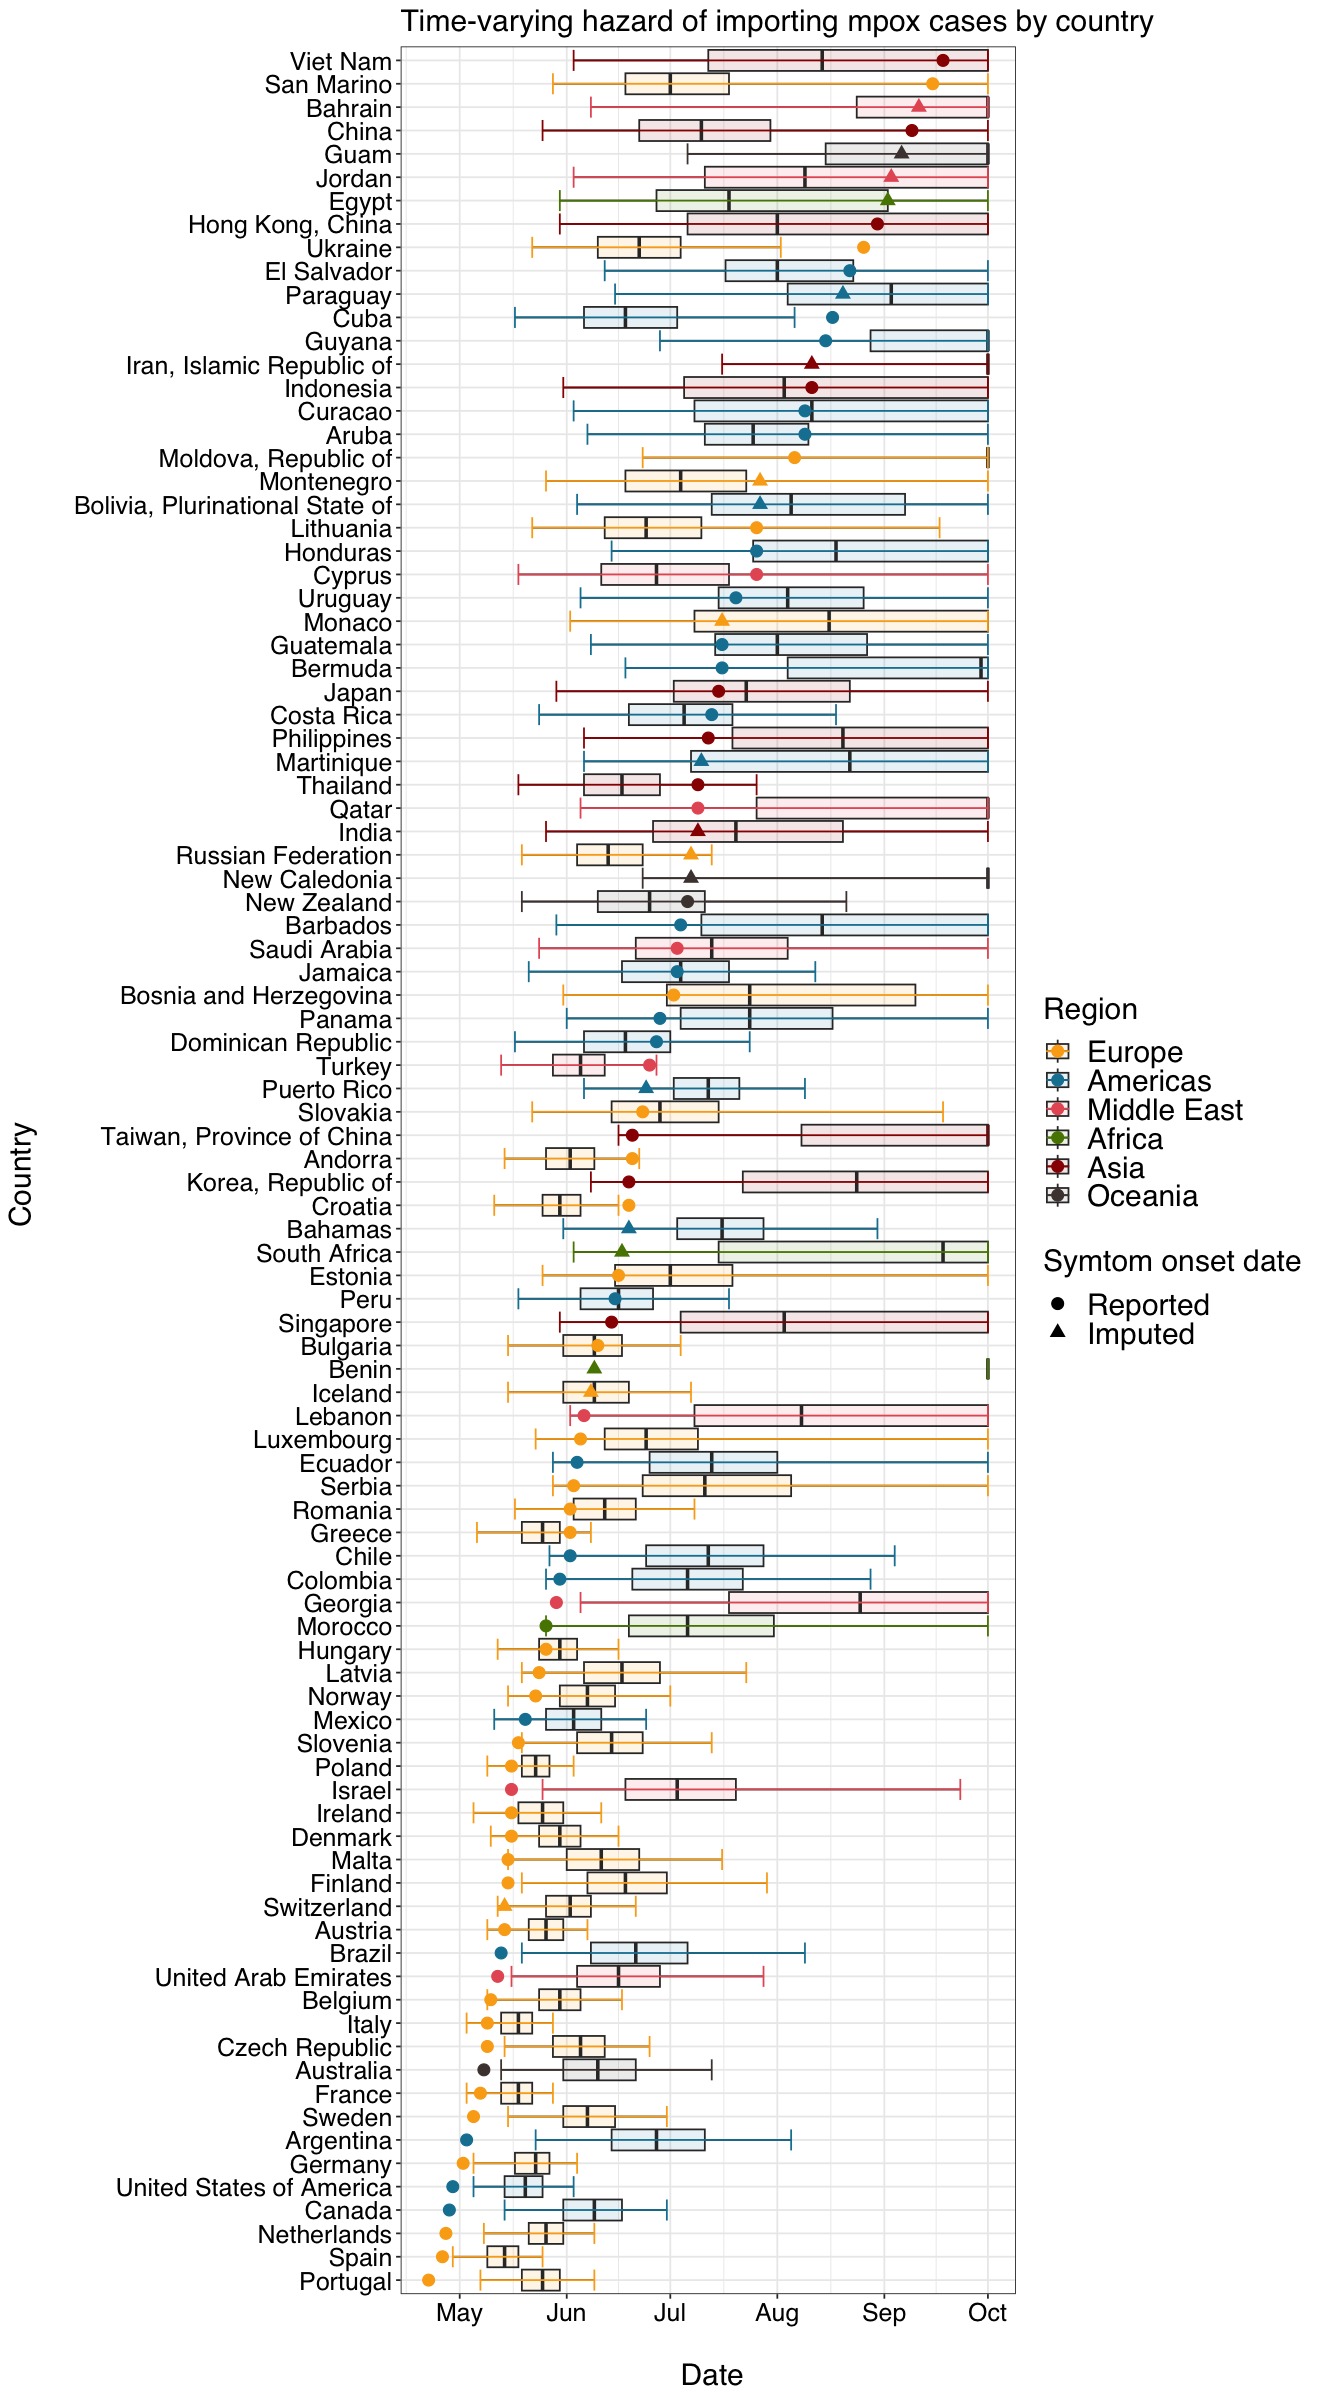

In [43]:
#### figure
rbind(quan_list0_fig, quan_list_fig) -> quan_list_all
Survf_region_fig %>% mutate(date_imp=date_imp_num+start_date-1) %>% 
dplyr::select(country, date_imp) %>% distinct() %>% arrange(date_imp) -> quan_imp_list0

df_input %>% rename(country=location) %>% 
mutate(imputed=case_when(is.na(date_import)~NA_character_, 
                         !is.na(date_import) & is.na(import_low) ~ c("Reported"), TRUE~c("Imputed"))) %>% 
dplyr::select(country, region, sub_region, imputed) %>% distinct() -> temp
merge(quan_imp_list0, temp, by=c("country")) -> quan_imp_list0

merge(quan_list_all, temp, by=c("country")) -> quan_list_all

options(repr.plot.width=11,repr.plot.height=20)
quan_list_all %>% arrange(date_imp_num) %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))) %>%
ggplot() +
geom_boxplot(aes(x = reorder(country,date_imp_num), 
                 ymin = q025, lower = q25, middle = q5, upper = q75, ymax = q975, fill=region), 
             stat = "identity", alpha=0.1) +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
geom_errorbar(aes(x = reorder(country,date_imp_num), ymin = q025, ymax = q975, color=region)) +
geom_point(data=quan_imp_list0 %>%
           filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                                   "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))), 
           aes(x=reorder(country,date_imp), y=date_imp, color=region, shape=imputed), size=3) +
scale_shape_manual("Symtom onset date", limits=c("Reported", "Imputed"), values=c(19, 17))+
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="Country \n", y="\n Date") +
ggtitle("Time-varying hazard of importing mpox cases by country") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=18, family="sans",color="black"),
        axis.text = element_text(size=15, family="sans",color="black"),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 18),
        plot.title = element_text(size=18, family="sans",color="black")) +
scale_y_date(date_labels = "%b", breaks="1 month") +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on")


#### coverage within the 50% and 95% range
quan_list_all %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))) %>%
mutate(date_imp=date_imp_num+start_date-1) %>% 
mutate(count_50=case_when(date_imp <= q25 & date_imp >= q75 ~ 1, TRUE ~ 0),
       count_95=case_when(date_imp <= q025 & date_imp >= q975 ~ 1, TRUE ~ 0)) -> counts
sum(counts$count_95)/nrow(counts); sum(counts$count_95)

In [44]:
df_input %>% rename(country=location) %>% filter(date >= start_date) %>% arrange(date, country) -> df_input_COI
df_input_COI %>% mutate(h_i=case_when(region == c("Europe") ~ F_i*exp(est_region$par)[1],
                                      region == c("Africa") ~ F_i*exp(est_region$par)[2],
                                      region == c("Americas") ~ F_i*exp(est_region$par)[3],
                                      region == c("Asia") ~ F_i*exp(est_region$par)[4],
                                      sub_region %in% c("Central Asia", "Western Asia") ~ F_i*exp(est_region$par)[5],
                                      region == c("Oceania") ~ F_i*exp(est_region$par)[6])) -> df_input_final

In [45]:
#### time-varying FOI
df_input %>% rename(country=location) %>% filter(date >= start_date) %>% arrange(date, country) -> df_input_COI
df_input_COI %>% mutate(h_i=case_when(region == c("Europe") ~ F_i*exp(est_region$par)[1],
                                      region == c("Africa") ~ F_i*exp(est_region$par)[2],
                                      region == c("Americas") ~ F_i*exp(est_region$par)[3],
                                      region == c("Asia") ~ F_i*exp(est_region$par)[4],
                                      sub_region %in% c("Central Asia", "Western Asia") ~ F_i*exp(est_region$par)[5],
                                      region == c("Oceania") ~ F_i*exp(est_region$par)[6]),
                        group=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"),
                                        TRUE ~ region)) %>%
mutate(imputed=case_when(is.na(date_import)~NA_character_, 
                         !is.na(date_import) & is.na(import_low) ~ c("Reported"), TRUE~c("Imputed"))) -> df_input_final

raw_global_FoI_data <- df_input_final
raw_global_FoI_data$date <- as.Date(raw_global_FoI_data$date)
raw_global_FoI_data$date_import <- as.Date(raw_global_FoI_data$date_import)

global_FoI_data <- raw_global_FoI_data %>% filter(censoring==0)
global_FoI_noimport_data <- raw_global_FoI_data %>% filter(censoring==1)

vis_data <- global_FoI_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

vis_data2 <- global_FoI_noimport_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

In [46]:
#### Time-varying FoI figure for countries with mpox importations
limit_set <- c(min(raw_global_FoI_data$h_i), max(raw_global_FoI_data$h_i))
colort_set <- c("white","red","purple","darkorchid4","black")
label_set = c("0.5", "1.5", "2.5", "3.5")
break_set = c(0.5, 1.5, 2.5, 3.5)

options(repr.plot.width=11,repr.plot.height=20)
vis_data %>% arrange(date_import) %>%
ggplot() +
  geom_raster(aes(x=reorder(country, date_import), y=date, fill=h_i), alpha=1) +
#   scale_fill_gradient(low="white", high="red", name="Force of infection") +
#   scale_fill_gradient2(low="white", mid="red", high="black", space = "Lab", name="Force of infection") +
#   viridis::scale_fill_viridis(option="rocket", direction=-1, name="Force of infection") +
  scale_fill_gradientn(name="Hazard rate (per day)", 
                       limits=limit_set,labels=label_set, breaks=break_set, colours = colort_set) +
  geom_point(aes(x=reorder(country, date_import), y=date_import, color=group, shape=imputed), size=3)+
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=18, family="sans",color="black"),
        axis.text = element_text(size=15, family="sans",color="black"),
#         panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 18),
        plot.title = element_text(size=18, family="sans",color="black")) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
scale_shape_manual("Symtom onset date", limits=c("Reported", "Imputed"), values=c(19, 17))+
labs(x="Country \n", y="\n Date") +
ggtitle("Countries with reported importation events") + 
scale_y_date(date_labels = "%b", breaks="1 month", expand=c(0,0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> FoI_model

In [47]:
#### Time-varying FoI figure for countries without any importation
# limit_set <- c(min(vis_data2$h_i), max(vis_data2$h_i))
# limit_set <- c(min(vis_data2$h_i), 0.1)
# colort_set <- c("white","red","purple","darkorchid4","black")
# label_set = c("0.01", "0.03", "0.05"); break_set = c(0.01, 0.03, 0.05)
# label_set = c("0.03", "0.06", "0.09"); break_set = c(0.03, 0.06, 0.09)

options(repr.plot.width=11,repr.plot.height=20)
vis_data2 %>% arrange(country) %>%
ggplot() +
  geom_raster(aes(x=reorder(country, desc(country)), y=date, fill=h_i), alpha=1) +
  scale_fill_gradientn(name="Force of infection", colours = c("white","red","purple","darkorchid4","black")) +
  scale_fill_gradientn(name="Force of infection", 
                       limits=limit_set,labels=label_set, breaks=break_set, colours = colort_set) +
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=18, family="sans",color="black"),
        axis.text = element_text(size=15, family="sans",color="black"),
#         panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 18),
        plot.title = element_text(size=18, family="sans",color="black")) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="", y="\n Date") +
ggtitle("Countries without any reported importation events") + 
scale_y_date(date_labels = "%b", breaks="1 month", expand=c(0,0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> fig_noimp

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


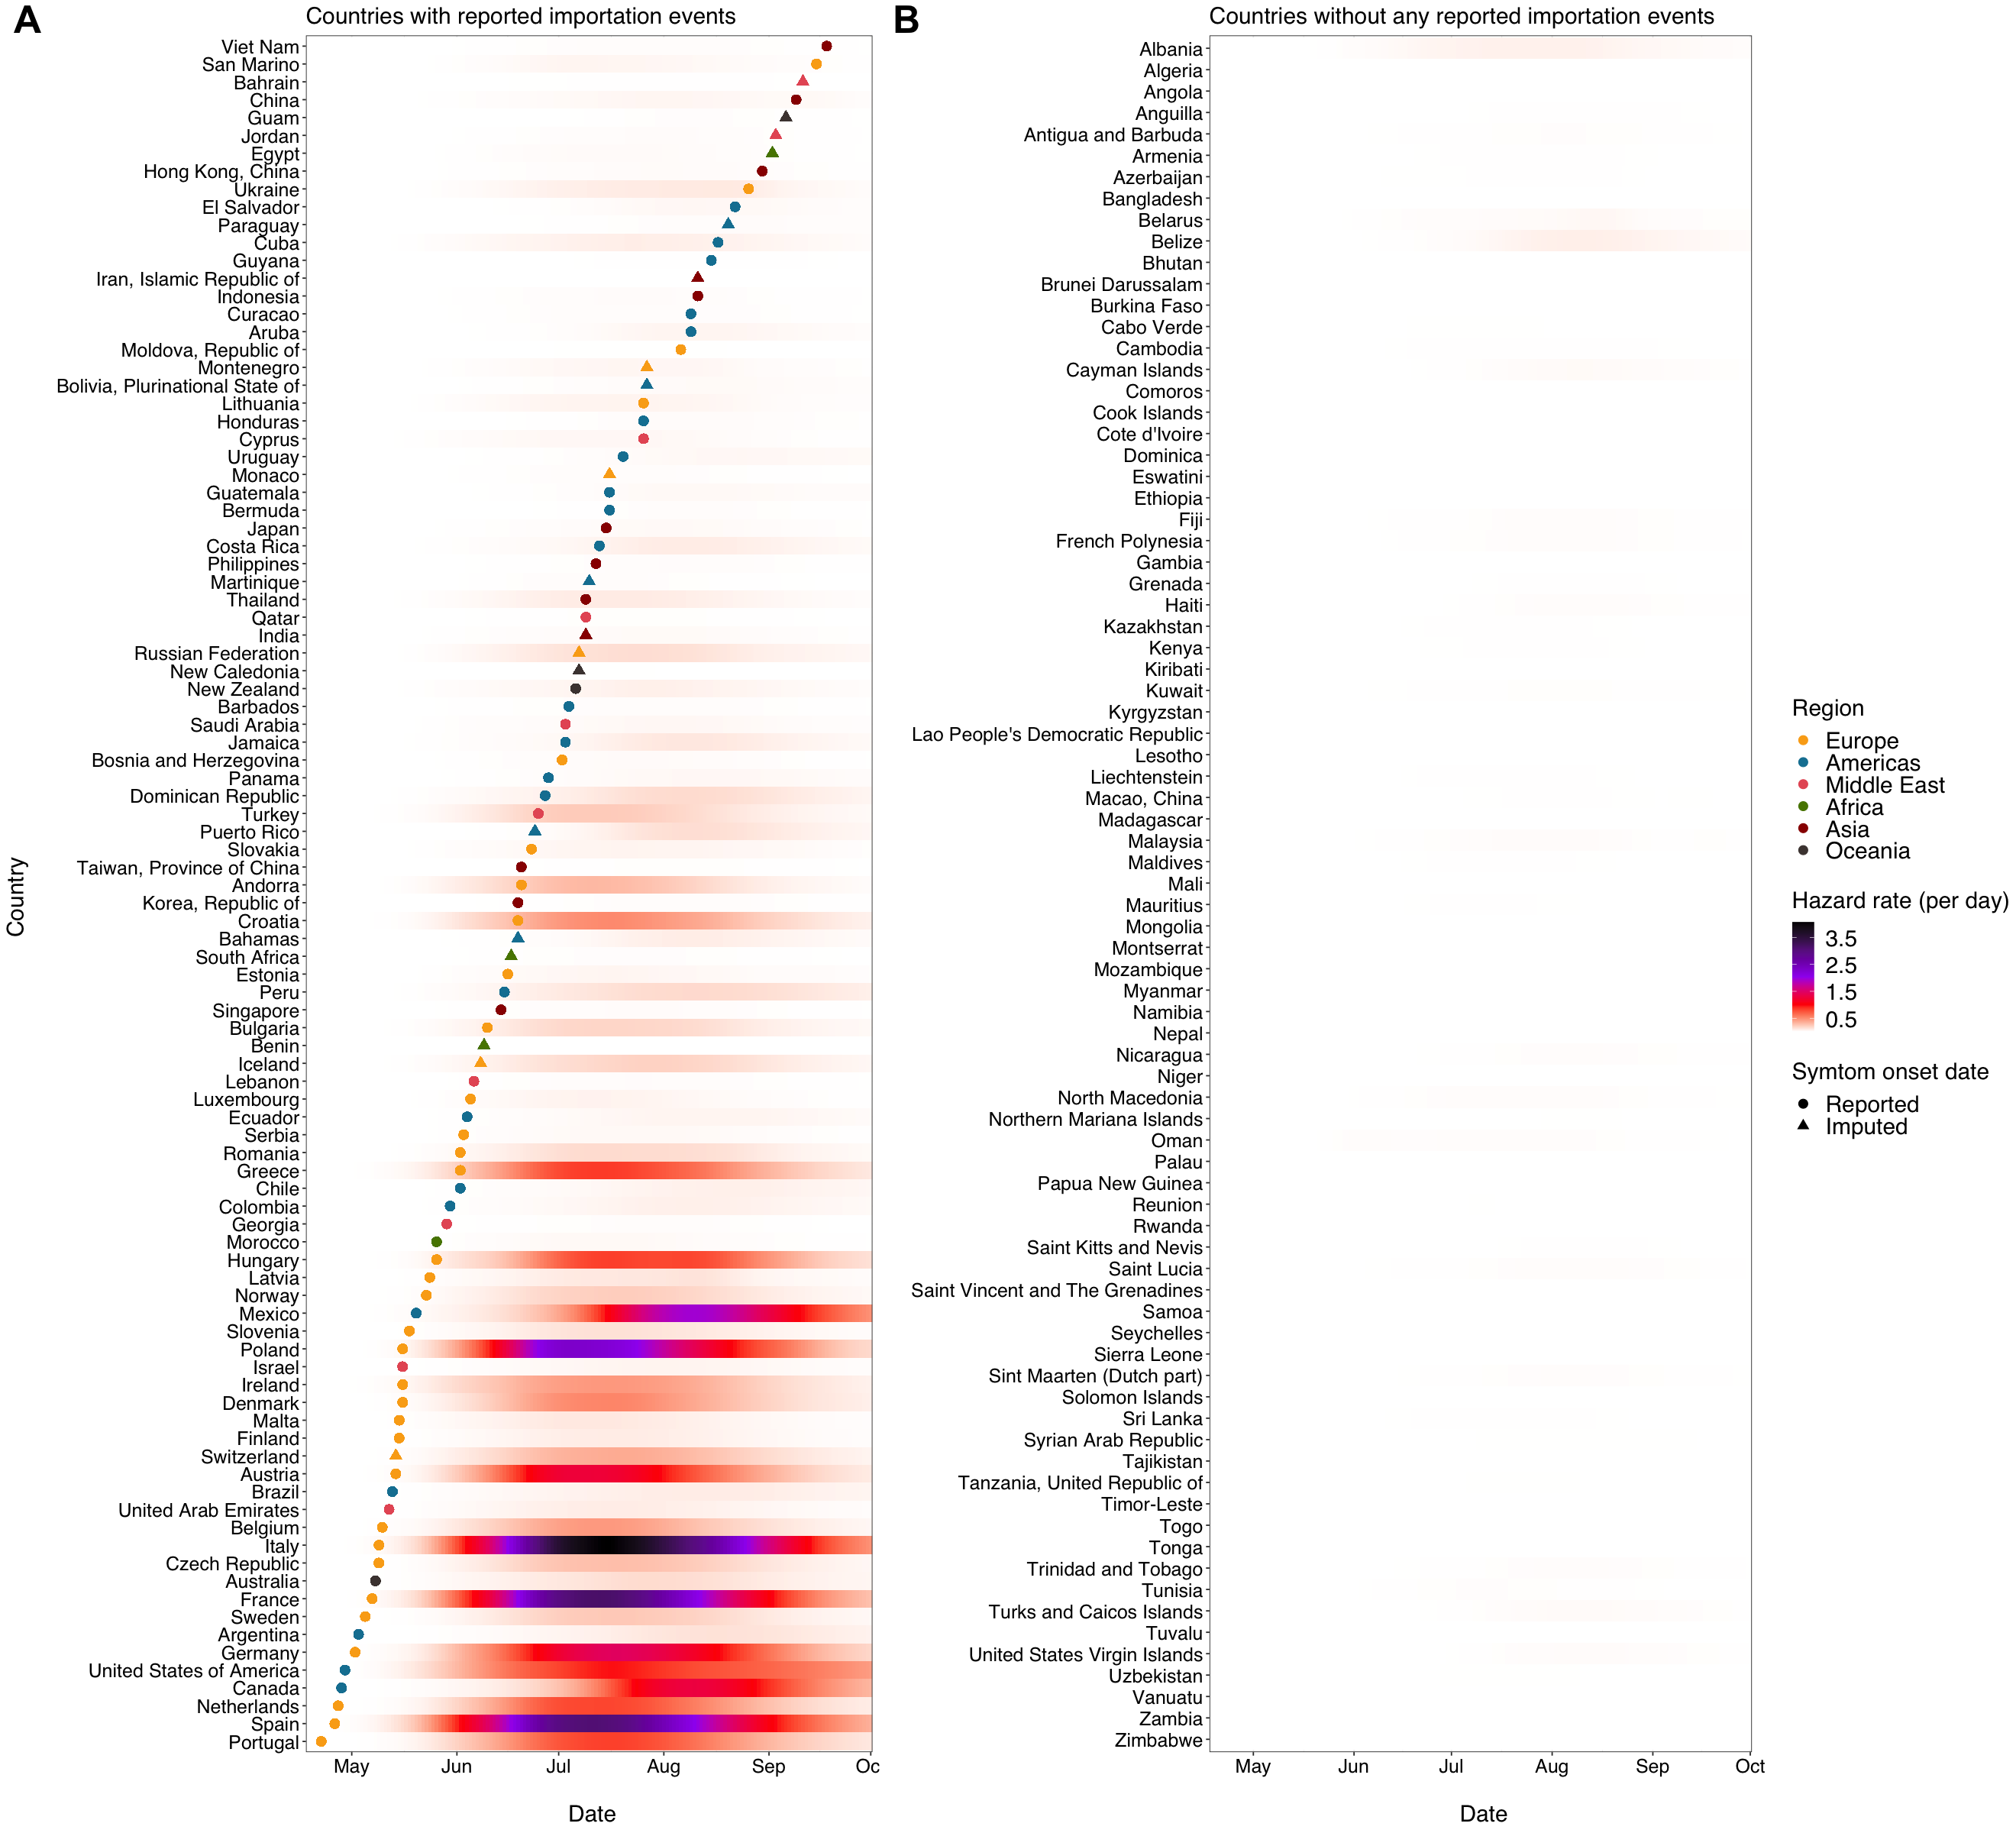

In [48]:
library(ggpubr)

options(repr.plot.width=22,repr.plot.height=20)
ggarrange(FoI_model, fig_noimp, ggplot() + theme_void(), nrow = 1, widths=c(1, 1, 0.03), 
          labels = c("A", "B",""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right")

In [49]:
#### The model without the depletion effect
df_input_counter2 %>% rename(country=location) %>% filter(date >= start_date) %>% arrange(date, country) -> df_input_counter_COI
df_input_counter_COI %>% 
mutate(region=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"),
                       TRUE ~ region)) %>%
mutate(h_i=case_when(region == c("Europe") ~ F_i*exp(est_region$par[1]),
                     region == c("Africa") ~ F_i*exp(est_region$par[2]),
                     region == c("Americas") ~ F_i*exp(est_region$par[3]),
                     region == c("Asia") ~ F_i*exp(est_region$par[4]),
                     region == c("Middle East") ~ F_i*exp(est_region$par[5]),
                     region == c("Oceania") ~ F_i*exp(est_region$par[6]))) -> df_counter_final

raw_global_FoI_data_counter <- df_counter_final
raw_global_FoI_data_counter$date <- as.Date(raw_global_FoI_data_counter$date)
raw_global_FoI_data_counter$date_import <- as.Date(raw_global_FoI_data_counter$date_import)

global_FoI_data <- raw_global_FoI_data_counter %>% filter(censoring==0)
global_FoI_noimport_data <- raw_global_FoI_data_counter %>% filter(censoring==1)

vis_data_counter <- global_FoI_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

vis_data_counter2 <- global_FoI_noimport_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


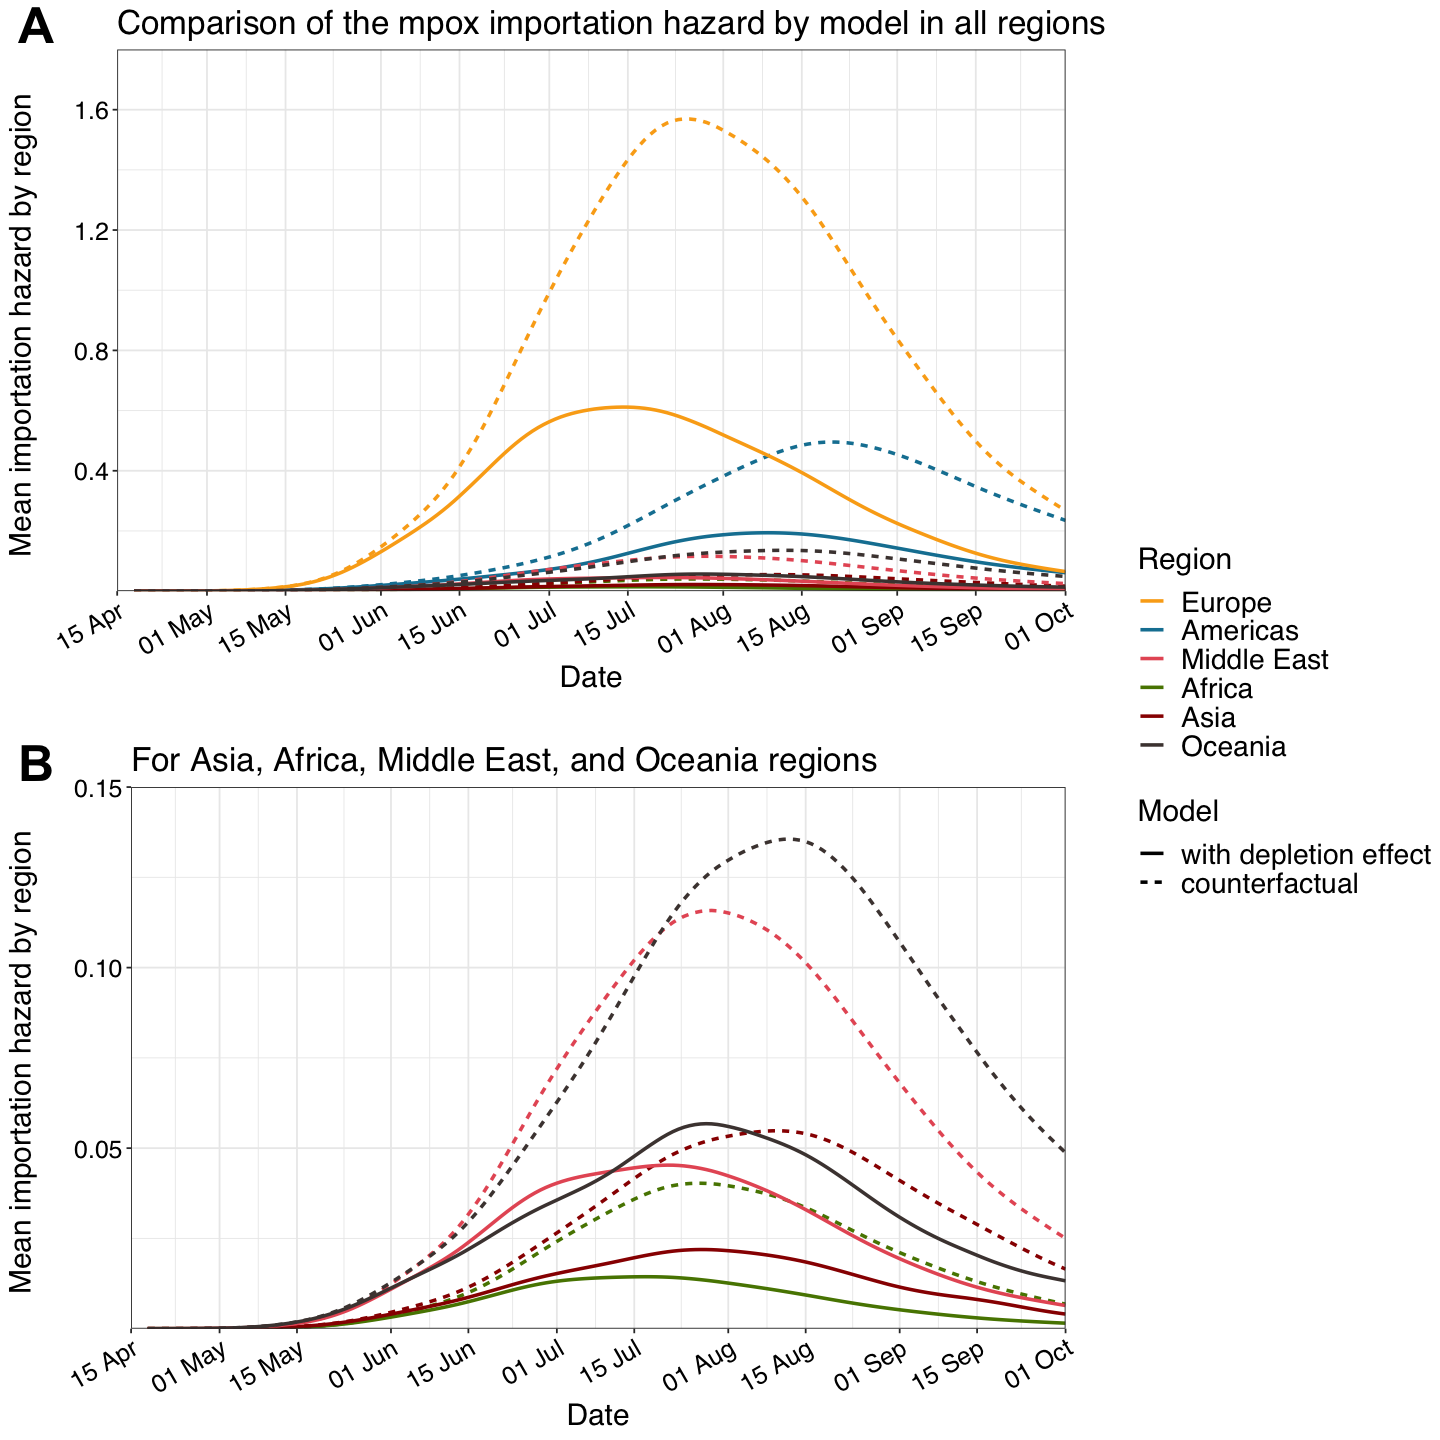

In [50]:
vis_data_counter %>% group_by(region, date) %>% summarize(h_i_region=mean(h_i)) %>% 
mutate(Model="counterfactual") -> temp2
vis_data %>% group_by(region, date) %>% summarize(h_i_region=mean(h_i)) %>% 
mutate(Model="with depletion effect") -> temp1

rbind(temp2, temp1) -> figure_line
figure_line$Model <- factor(figure_line$Model, levels=c("with depletion effect", "counterfactual"))

options(repr.plot.width=12,repr.plot.height=6)
ggplot(figure_line, aes(x = date, y=h_i_region, color = region, linetype = Model)) +
geom_line(size=1) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
    plot.title = element_text(size=20, family="sans",color="black"),
    axis.title = element_text(size=18, family="sans",color="black"),
    axis.text = element_text(size=15, family="sans",color="black"),
    legend.title = element_text(size = 18), legend.text = element_text(size = 17),
    axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Date") +
ylab("Mean importation hazard by region \n") +
ggtitle("Comparison of the mpox importation hazard by model in all regions") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(figure_line$date)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(0.4, 0.8, 1.2, 1.6)) +
coord_cartesian(ylim = c(0,1.8)) -> fig1



vis_data_counter %>% group_by(region, date) %>% summarize(h_i_region=mean(h_i)) %>% 
mutate(Model="counterfactual") %>% filter(!region %in% c("Europe", "Americas")) -> temp2
vis_data %>% group_by(region, date) %>% summarize(h_i_region=mean(h_i)) %>% 
mutate(Model="with depletion effect") %>% filter(!region %in% c("Europe", "Americas")) -> temp1

rbind(temp2, temp1) -> figure_line
figure_line$Model <- factor(figure_line$Model, levels=c("with depletion effect", "without depletion effect"))

options(repr.plot.width=12,repr.plot.height=6)
ggplot(figure_line, aes(x = date, y=h_i_region, color = region, linetype = Model)) +
geom_line(size=1) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
    plot.title = element_text(size=20, family="sans",color="black"),
    axis.title = element_text(size=18, family="sans",color="black"),
    axis.text = element_text(size=15, family="sans",color="black"),
    legend.title = element_text(size = 18), legend.text = element_text(size = 17),
    axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Date") +
ylab("Mean importation hazard by region \n") +
ggtitle("For Asia, Africa, Middle East, and Oceania regions") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(figure_line$date)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(0.05, 0.10, 0.15)) +
coord_cartesian(ylim = c(0,0.15)) +
guides(color = guide_legend(order = 1), flinetypeill  = guide_legend(order = 2)) -> fig2

options(repr.plot.width=12,repr.plot.height=12)

ggarrange(fig1, ggplot() + theme_void(), 
          ggplot() + theme_void(), ggplot() + theme_void(),
          fig2, ggplot() + theme_void(), ncol = 2, nrow = 3, 
          widths=c(1, 0.05, 1, 0.05, 1, 0.05), heights=c(1, 0.05, 1), 
          labels = c("A", "", "", "", "B", ""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right")

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


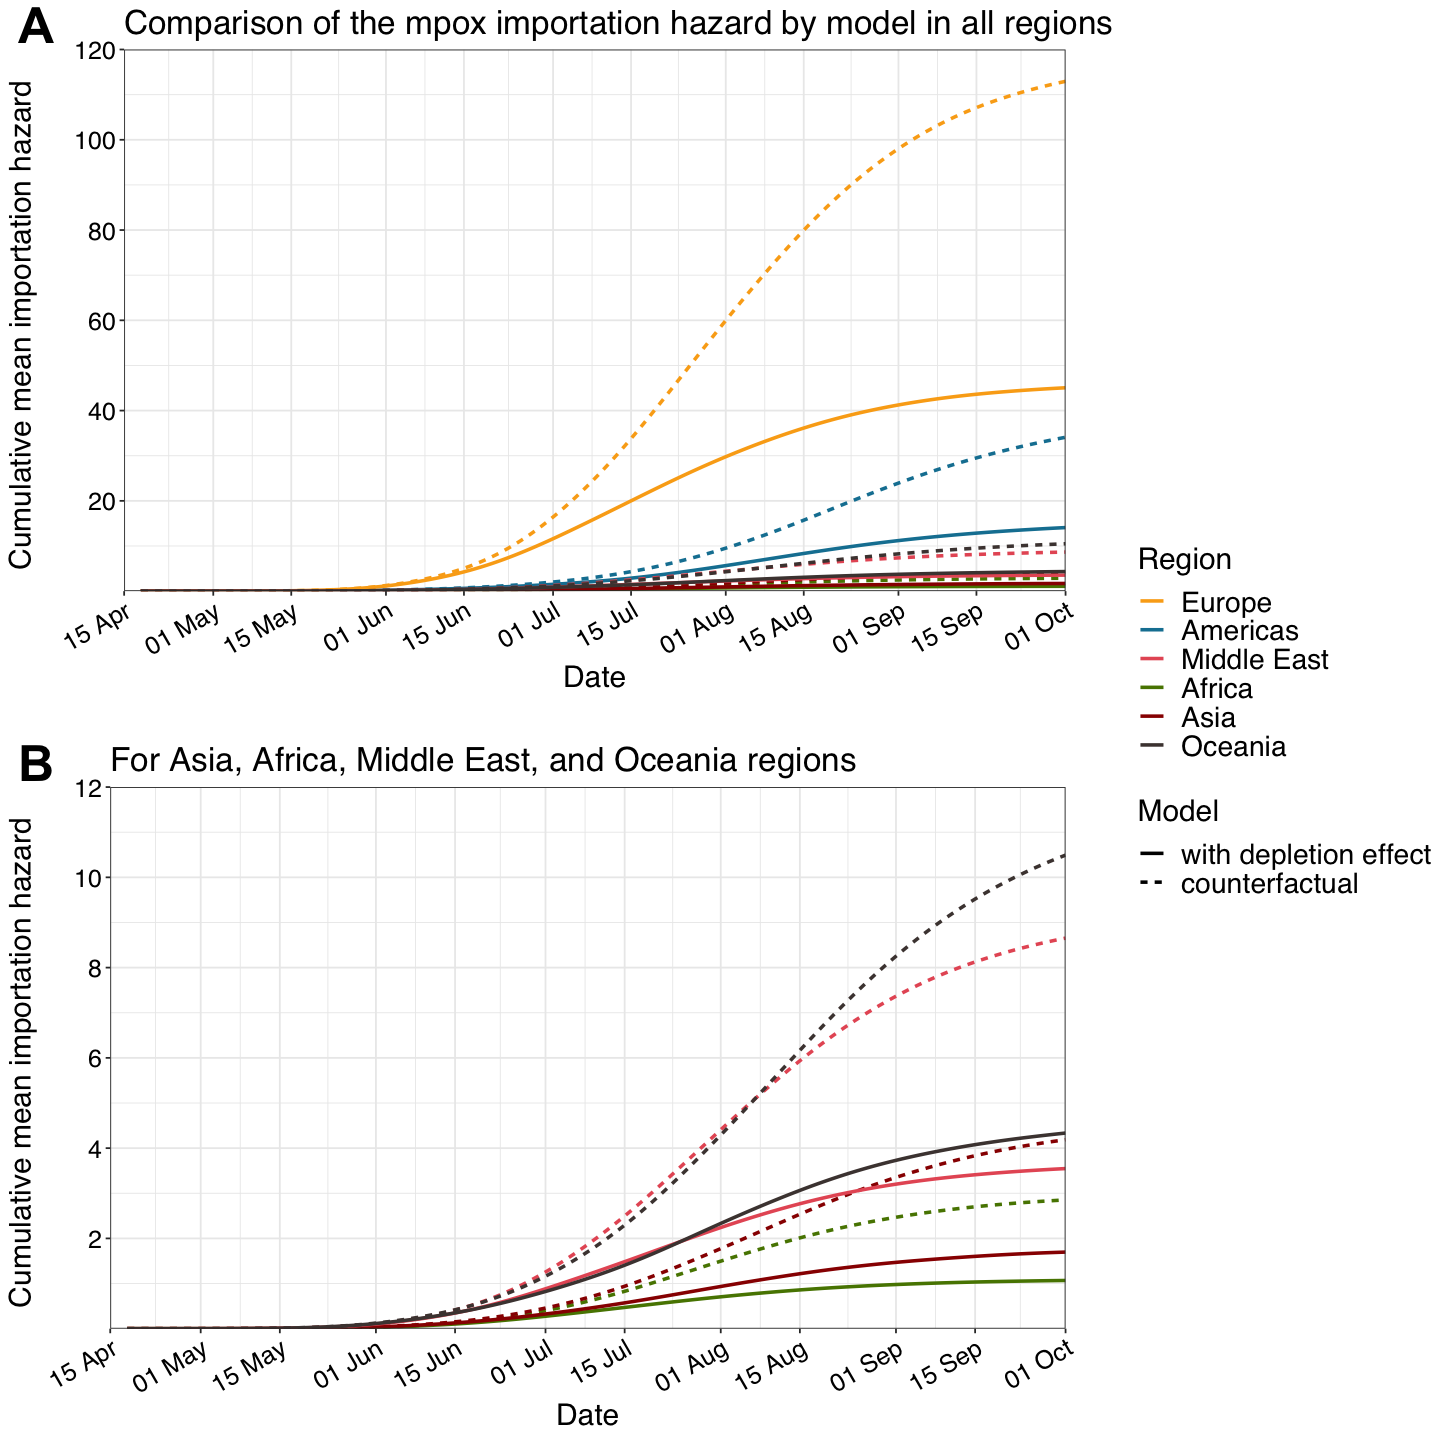

In [51]:
vis_data_counter %>% group_by(region, date) %>% summarize(h_i_region=mean(h_i)) %>% 
mutate(Model="counterfactual") -> temp2
vis_data %>% group_by(region, date) %>% summarize(h_i_region=mean(h_i)) %>% 
mutate(Model="with depletion effect") -> temp1

rbind(temp2, temp1) -> figure_line
figure_line$Model <- factor(figure_line$Model, levels=c("with depletion effect", "counterfactual"))

figure_line %>% group_by(Model, region) %>% mutate(cum_h_i=cumsum(h_i_region)) %>% ungroup() -> figure_line2

options(repr.plot.width=12,repr.plot.height=6)
ggplot(figure_line2, aes(x = date, y=cum_h_i, color = region, linetype = Model)) +
geom_line(size=1) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
    plot.title = element_text(size=20, family="sans",color="black"),
    axis.title = element_text(size=18, family="sans",color="black"),
    axis.text = element_text(size=15, family="sans",color="black"),
    legend.title = element_text(size = 18), legend.text = element_text(size = 17),
    axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Date") +
ylab("Cumulative mean importation hazard \n") +
ggtitle("Comparison of the mpox importation hazard by model in all regions") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(figure_line$date)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(20, 40, 60, 80, 100, 120)) +
coord_cartesian(ylim = c(0,120))-> fig1



vis_data_counter %>% group_by(region, date) %>% summarize(h_i_region=mean(h_i)) %>% 
mutate(Model="counterfactual") %>% filter(!region %in% c("Europe", "Americas")) -> temp2
vis_data %>% group_by(region, date) %>% summarize(h_i_region=mean(h_i)) %>% 
mutate(Model="with depletion effect") %>% filter(!region %in% c("Europe", "Americas")) -> temp1

rbind(temp2, temp1) -> figure_line
figure_line$Model <- factor(figure_line$Model, levels=c("with depletion effect", "without depletion effect"))

figure_line %>% group_by(Model, region) %>% mutate(cum_h_i=cumsum(h_i_region)) %>% ungroup() -> figure_line2

options(repr.plot.width=12,repr.plot.height=6)
ggplot(figure_line2, aes(x = date, y=cum_h_i, color = region, linetype = Model)) +
geom_line(size=1) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
    plot.title = element_text(size=20, family="sans",color="black"),
    axis.title = element_text(size=18, family="sans",color="black"),
    axis.text = element_text(size=15, family="sans",color="black"),
    legend.title = element_text(size = 18), legend.text = element_text(size = 17),
    axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Date") +
ylab("Cumulative mean importation hazard \n") +
ggtitle("For Asia, Africa, Middle East, and Oceania regions") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(figure_line$date)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(2, 4, 6, 8, 10, 12)) +
coord_cartesian(ylim = c(0,12)) +
guides(color = guide_legend(order = 1), flinetypeill  = guide_legend(order = 2)) -> fig2

options(repr.plot.width=12,repr.plot.height=12)

ggarrange(fig1, ggplot() + theme_void(), 
          ggplot() + theme_void(), ggplot() + theme_void(),
          fig2, ggplot() + theme_void(), ncol = 2, nrow = 3, 
          widths=c(1, 0.05, 1, 0.05, 1, 0.05), heights=c(1, 0.05, 1), 
          labels = c("A", "", "", "", "B", ""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right")

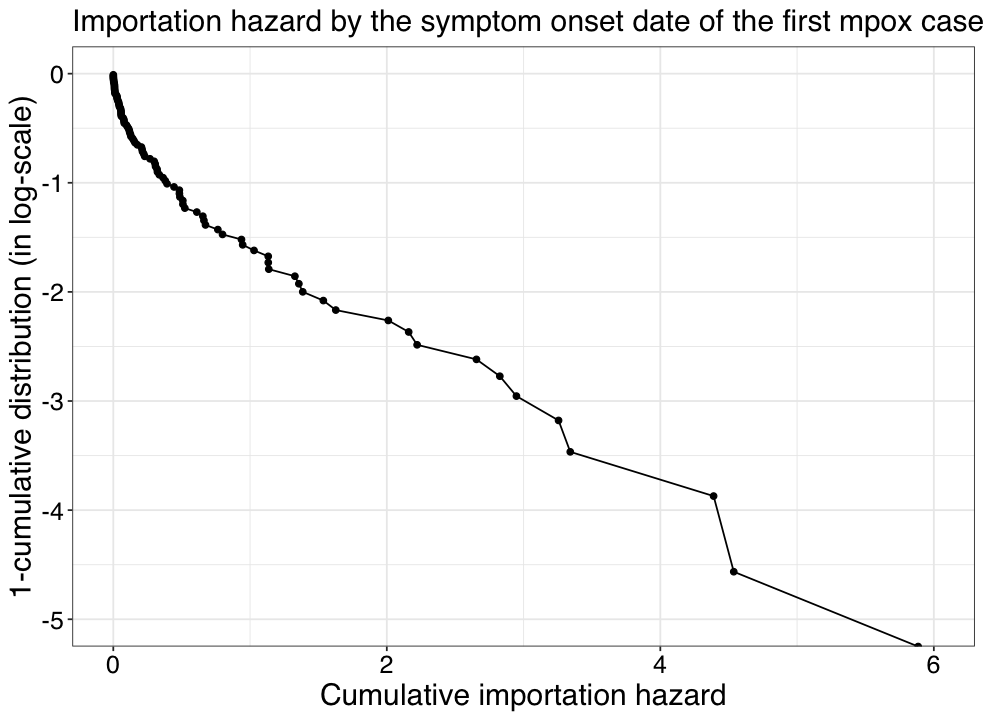

In [52]:
#### checking the linearity of log plot
library(ggrepel)
raw_global_FoI_data %>% filter(censoring==0) %>% dplyr::select(country, group, date, date_import, h_i) %>%
arrange(country, date) %>% group_by(country) %>% mutate(cum_h_i=cumsum(h_i)) %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                        "United Kingdom"))) %>% ungroup() -> cum_global_FoI_data

## distribution of the CFOI at the date of importation
cum_global_FoI_data %>% mutate(diff=date_import-date) %>% filter(diff==0) -> temp
temp %>% group_by(cum_h_i) %>% summarise(n=n()) -> temp2
temp %>% group_by(cum_h_i) %>% summarise(n=n(), across()) %>% mutate(prop_n=n/sum(temp2$n)) %>% 
mutate(cum_prop_n=cumsum(prop_n), cum_prop_n2=log(1-cum_prop_n), log_x=log(cum_h_i)) -> temp_figure

options(repr.plot.width=8.2,repr.plot.height=6)
temp_figure %>%
ggplot(aes(x=cum_h_i, y=cum_prop_n2, label=country)) +
geom_point() +
geom_line() +
# geom_label_repel(box.padding = 0.35, point.padding = 0.5, segment.color = 'grey50') +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=18, family="sans",color="black")) +
scale_y_continuous(limits=c(-5, 0)) + 
scale_x_continuous(limits=c(0, 6)) + 
ggtitle("Importation hazard by the symptom onset date of the first mpox case") + 
labs(x="Cumulative importation hazard", 
     y="1-cumulative distribution (in log-scale)")